#### Load and Prepare the Dataset

In [6]:
import pandas as pd
import numpy as np

# Load your merged and feature-engineered dataset
df = pd.read_csv('../data/features_btc.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Drop 'Date' (not needed for training)
features = df.drop(columns=['Date', 'Close'])
target = df['Close'].values.reshape(-1, 1)


### Scale Features and Target Separately

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Scale input features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(features)

# Scale target values (Close price)
price_scaler = MinMaxScaler()
y_scaled = price_scaler.fit_transform(target)


#### Create LSTM Sequences

In [8]:
def create_sequences(X, y, window=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window_size = 10
X, y = create_sequences(X_scaled, y_scaled, window=window_size)


#### Train-Test Split

In [9]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Build and Train the LSTM Model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


/Users/rahulmansharamani/Desktop/Files/Github/llm-enhanced-btc-predictor/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1152e-04 - val_loss: 0.0017
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0320e-04 - val_loss: 0.0015
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3647e-04 - val_loss: 0.0046
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5438e-04 - val_loss: 0.0018
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2915e-04 - val_loss: 0.0033
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3604e-04 - val_loss: 0.0011
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3113e-04 - val_loss: 0.0013
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9106e-04 - val_loss: 0.0010
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8061e-04 - val_loss: 0.0011
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6313e-04 - val_loss: 0.0029
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

#### Make Predictions and Inverse Transform

In [11]:
y_pred = model.predict(X_test)

# Inverse scale both y_test and predictions to original price
y_pred_rescaled = price_scaler.inverse_transform(y_pred)
y_test_rescaled = price_scaler.inverse_transform(y_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### Plot Actual vs Prediction

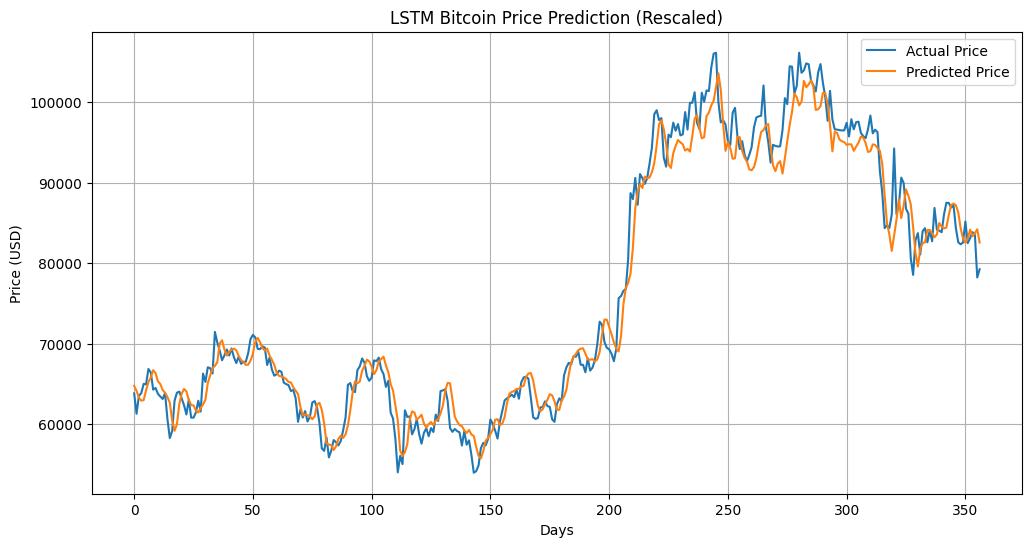

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('LSTM Bitcoin Price Prediction (Rescaled)')
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


#### Metrics

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))


RMSE: 2682.38
MAE: 2024.7
